In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
import pymc3 as pm
import numpy as np

import logging
import os

import torch
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

In [160]:
# load data
data = pd.read_csv('processed_sbwu_data.csv')
X = data.drop('success', axis=1)
y = data['success']

In [161]:
# # load data
# data = pd.read_csv('diabetes.csv')
# X = data.drop('Outcome', axis=1)
# y = data['Outcome']

In [162]:
# make test/ train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#scale and re-assign labels
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [163]:
# add ones col for bias
ones_column_train = np.full(fill_value= 1, shape=(X_train_scaled.shape[0], 1))
ones_column_test = np.full(fill_value= 1, shape=(X_test_scaled.shape[0], 1))
X_train_scaled = np.append(ones_column_train, X_train_scaled, 1)
X_test_scaled = np.append(ones_column_test, X_test_scaled, 1)

#convert all to numpy array
X_train_scaled = np.asarray(X_train_scaled)
X_test_scaled = np.asarray(X_test_scaled)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [219]:
prior_var = 10**-1
# prior_var = 2

def sigmoid(x):
    return 1/(1 + np.exp(-(x)))

def predict(x, beta):
    return sigmoid(np.dot(x, beta))


# should all by numpy arrays
def gradient(x, y, beta, n):
    batch_size = x.shape[0]
    predicted_expectations = predict(x, beta)
    residuals = np.zeros_like(beta)
    
    grad = -beta/np.sqrt(prior_var) + n/batch_size * np.dot(x.T, (y - predict(x, beta)))
    return grad

def cross_entropy(x, y, beta):
    return np.mean(y * np.log(predict(x, beta)) + (1 - y) * np.log(predict(x, -beta)))

def objective(x, y, beta):
    return -1/(2 * prior_var) * np.sum(beta **2) + -log_loss(y, predict(x, beta), normalize=False)

def accuracy(x, y, beta):
    predictions = predict(x, beta)
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    return 1 - np.mean(np.abs(y - predictions))
    

In [220]:
def sk_objective(x, y, beta):
    pred = predict(x, beta)
    return -log_loss(y, pred)

In [221]:
def sgd(gradient, x, y, start, learn_rate=0.0001, batch_size=48, n_iter=300, tolerance=1e-06, dtype="float64", seed=None):
    rng = np.random.default_rng(seed=seed)
    num_obs = x.shape[0]
    vector = start
    
    for i in range(n_iter):
        x, y = shuffle(x, y, random_state=seed)
        
        for start_index in range(0, num_obs, batch_size):
            stop = start_index + batch_size
            x_batch, y_batch = x[start_index:stop], y[start_index:stop]
            grad = np.array(gradient(x_batch, y_batch, vector, num_obs))
            diff = learn_rate * grad
                            
            if np.all(np.abs(diff) <= tolerance):
                break
              
            vector += diff
        accuracy_train.append(accuracy(x, y, vector))
        accuracy_test.append(accuracy(X_test_scaled, y_test, vector))
        objective_train.append(objective(x, y, vector))
        objective_test.append(objective(X_test_scaled, y_test, vector))
    return vector

In [222]:
objective_train = []
objective_test = []
accuracy_train = []
accuracy_test = []
sk_obj = []
start = np.zeros(shape=(len(X_train_scaled[0]),))
beta_hat = sgd(gradient, X_train_scaled, y_train, start) 

array([ 1.39658736,  0.12801778, -0.01294084, -0.16454716,  0.32663284,
        0.24198858,  0.36237762,  0.3493581 , -0.34913767,  0.13255249,
       -0.13206718, -0.08261917,  0.05202217, -0.01604242, -0.29928619,
       -0.07331215])

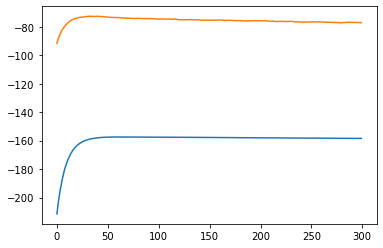

In [223]:
plt.plot(objective_train)
plt.plot(objective_test)
# plt.ylim(-0.8, -0.4)
# plt.plot(accuracy_train)
# plt.plot(accuracy_test)
# plt.plot(sk_obj)
# plt.show()
# objective_train
beta_hat

array([ 1.19456420e+00,  1.29139003e-01, -1.14438220e-01, -1.42356419e-01,
        4.23800668e-02,  3.60244164e-01,  4.81733072e-04,  2.34670540e-01,
       -7.90442843e-02, -1.41069803e-01, -8.80601991e-02,  1.66180159e-01,
       -6.16011739e-02, -7.13893796e-02,  6.63360662e-02,  4.02850916e-01,
       -1.47662915e-02,  1.35355265e-01, -2.69109924e-01, -1.96102216e-01,
        1.11119245e-02, -7.18447110e-02, -3.61345663e-01, -2.86951000e-02])

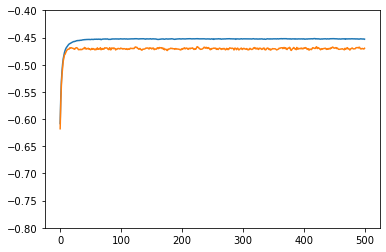

In [155]:
plt.plot(objective_train)
plt.plot(objective_test)
plt.ylim(-0.8, -0.4)
# plt.plot(accuracy_train)
# plt.plot(accuracy_test)
# plt.plot(sk_obj)
# plt.show()
# objective_train
beta_hat

array([ 1.19648937,  0.13158185, -0.12196881, -0.1489246 ,  0.04289036,
        0.35157157,  0.00333448,  0.2375295 , -0.06418597, -0.15543928,
       -0.09517882,  0.16418011, -0.06602835, -0.07162752,  0.06825453,
        0.40507179, -0.02045705,  0.1284871 , -0.2585246 , -0.19288935,
        0.00944169, -0.07314378, -0.35900929, -0.03820689])

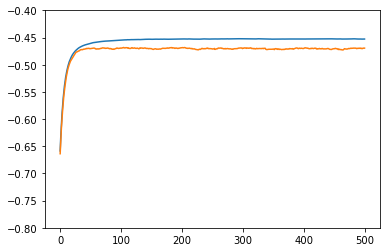

In [138]:
plt.plot(objective_train)
plt.plot(objective_test)
plt.ylim(-0.8, -0.4)
# plt.plot(accuracy_train)
# plt.plot(accuracy_test)
# plt.plot(sk_obj)
# plt.show()
# objective_train
beta_hat

In [72]:
cross_entropy(X_train_scaled, y_train, beta_hat)

-0.43733604890112915

In [58]:
cross_entropy(X_test_scaled, y_test, beta_hat)

-0.4965343829304537

In [51]:
cross_entropy(X_test_scaled, y_test, np.zeros(shape=(len(X_test_scaled[0]),)))

-0.6931471805599453

In [24]:
predict(X_train_scaled, beta_hat)
beta_hat

array([ 1.4577203 ,  0.78913451, -0.12769083, -0.07682875,  0.24923289,
        1.01341954,  0.17124172,  0.5300878 , -0.66820067,  0.11938191,
       -0.60398239, -0.2790398 , -0.0599156 , -0.17984707, -0.51733803,
       -0.03005206])

In [120]:
rtw_success = data[['RTW','success']] 
np.count_nonzero(rtw_success == [1, 1])
# len(rtw_success)

# zz = 0
# zo = 0
# oz = 0
# oo = 0

# for row in rtw_success:
#     if row == [0, 0]:
#         zz += 1
#     elif row == [0, 1]:
#         zo += 1
#     elif row == [1, 0]:
#         oz += 1
#     else:
#         oo += 1
# print(zz, zo, oz, oo)
# print(rtw_success)


#plt.scatter(data['RTW'], data['success'])

#412 0, 0
# 213 1, 0
# 689 0, 1
# 490 1, 1

np.corrcoef(data['RTW'], data['success'])

array([[ 1.        , -0.02121564],
       [-0.02121564,  1.        ]])

In [69]:
p = predict(X_train_scaled, beta_hat)

p[p > 0.5] = 1
p[p <= 0.5] = 0

p

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [70]:
np.mean(np.abs(y_train - p))

0.19047619047619047

In [71]:
beta_hat

array([ 1.47208446,  0.79298884, -0.14247025, -0.06347246,  0.26644026,
        1.03382142,  0.1706488 ,  0.54175522, -0.65051701,  0.10689832,
       -0.60305005, -0.28991789, -0.04518417, -0.17250464, -0.55799793,
       -0.03286776])